In [40]:
import pandas as pd
import os
from matplotlib import pylab as plt


%matplotlib inline
results_path_base = '/home/bolster/src/aietes/results/'
results_path_600 = '/home/bolster/src/aietes/results/Malicious Behaviour Trust Comparison-2016-03-21-02-43-30'
results_path_60 = '/home/bolster/src/aietes/results/Malicious Behaviour Trust Comparison-2016-03-21-15-26-48'
results_path_10 = '/home/bolster/src/aietes/results/Malicious Behaviour Trust Comparison-2016-03-21-16-52-40'
results_path_28800_duration_no_drag="/home/bolster/src/aietes/results/Malicious Behaviour Trust Comparison-2016-03-21-18-43-59"
results_path_good_as_of_monday210416 = "/home/bolster/src/aietes/results/Malicious Behaviour Trust Comparison-2016-03-22-01-56-00"

files = filter(os.path.isdir, (os.path.join(results_path_base,d) for d in os.listdir(results_path_base)))
files = [os.path.join(results_path_base, f) for f in files] # add path to each file
files.sort(key=lambda x: os.path.getmtime(x))
latest_results = files[-1]
print latest_results

fig_path = '/home/bolster/src/thesis/papers/active/16_MASS/figures'

with pd.get_store(latest_results + '.h5') as store:
    print store.keys()
    positions = store.positions
    trust_observations = store.trust
    trust_observations.columns.name='metric'
trust_observations.head()

/home/bolster/src/aietes/results/Malicious Behaviour Trust Comparison-2016-03-22-01-56-00
['/positions', '/rx', '/stats', '/trust', '/trust_accessories', '/tx', '/tx_queue']


metric                              INDD      INHD     Speed
var    run observer t target                                
Shadow 0   Alfa     1 Alfa     32.724062  0.031470  0.029855
                      Bravo    48.488312  0.024435  0.026818
                      Charlie  59.515580  0.011774  0.023877
                      Delta    42.353590  0.032531  0.036401
                      Echo     38.854457  0.022439  0.037671

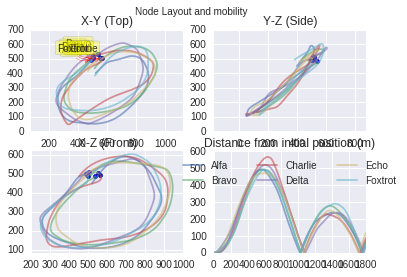

In [32]:
from bounos.ChartBuilders import plot_axes_views_from_positions_frame

_=plot_axes_views_from_positions_frame(positions.xs('Waypoint', level='var'))


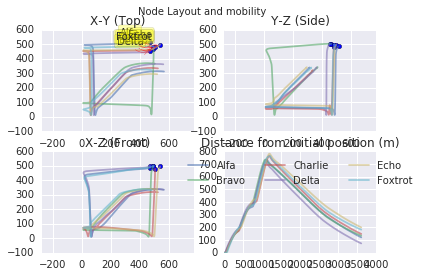

In [419]:
fig_bigdrag

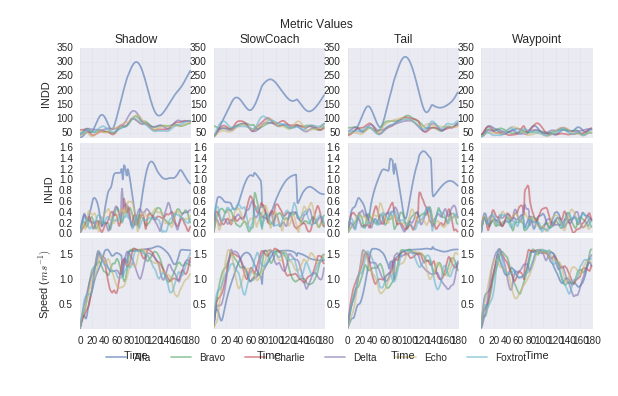

In [118]:
def plot_behaviour_metric_graph(data, observer = 'Bravo', run = 0, force_ymin=None, title=None, y_label_map=None, trust_period=10, save_fig=False):
    from matplotlib.gridspec import GridSpec

    _bevs = set(data.index.get_level_values('var'))
    _metrics = list(data.columns)
    fig = plt.figure(figsize=(8, 5), dpi=80)
    base_ax = fig.add_axes([0, 0, 1, 1], )
    base_ax.set_axis_off()
    gs = GridSpec(len(_metrics), len(_bevs))
    axes = [[None for _ in range(len(_metrics))] for _ in range(len(_bevs))]
    # Column Behaviours
    for i, (behaviour, bev_df) in enumerate(data.groupby(level='var')):
        # Row Metrics
        metrics_df = bev_df
        if 'run' in bev_df.index.names:
            metrics_df = metrics_df.xs(run, level='run', drop_level=True)
        if 'observer' in bev_df.index.names:
            metrics_df = metrics_df.xs(observer, level='observer')
        for j, metric in enumerate(metrics_df):
            ax = fig.add_subplot(gs[j, i])
            for target, target_df in metrics_df[metric].groupby(level='target'):
                ax.plot(target_df.values, label=target,alpha=0.6)
            if j == 0:
                ax.set_title(behaviour)
            ax.grid(True, alpha=0.2)
            ax.autoscale_view(scalex=False, tight=True)

            # Metric label on left most graph
            if i == 0:
                if y_label_map is None:
                    ax.set_ylabel(metric)
                else:
                    ax.set_ylabel(smart_dict(y_label_map)[metric])

            #ax.legend()
            #
            # Last Metric Behaviour (Legend)
            if j == len(_metrics) - 1:
                ax.set_xlabel("Time")
                if i == 0:
                    ax.legend(loc="lower center",
                              bbox_to_anchor=(0, 0, 1, 1),
                              bbox_transform=fig.transFigure,
                              ncol=6, frameon=False, prop={'size':10})
                else:
                    pass
            else:
                [l.set_visible(False) for l in ax.get_xticklabels()]
            ax.grid(color='lightgray')
            axes[i][j] = ax
    # For each metric row
    for j in range(len(_metrics)):
        (m_ymin, m_ymax) = (float('inf'), float('-inf'))
        (m_xmin, m_xmax) = (float('inf'), float('-inf'))
        # Take the max limits across all behaviours
        for i in range(len(_bevs)):
            (ymin, ymax) = axes[i][j].get_ylim()
            (xmin, xmax) = axes[i][j].get_xlim()
            m_ymax = max(ymax, m_ymax)
            m_ymin = min(ymin, m_ymin)
            m_xmax = max(xmax, m_xmax)
            m_xmin = min(xmin, m_xmin)
        
        m_ymin = m_ymin if force_ymin is None else force_ymin
        # Reset the rows limits
        for i in range(len(_bevs)):
            axes[i][j].set_ylim((m_ymin*0.9, m_ymax * 1.1))
            axes[i][j].set_xlim((0, m_xmax))
        
    fig.subplots_adjust(
            left=0.09, bottom=0.12, right=0.98, top=0.9, wspace=0.2, hspace=0.05)
    if title is not None:
        fig.suptitle(title, fontsize=12)
    if save_fig:
        fig.savefig(os.path.join(fig_path,title.replace(' ','_'))+'.png', transparent=True)
    else:
        fig.show()

    return fig

fig = plot_behaviour_metric_graph(trust_observations, y_label_map={'Speed':'Speed ($ms^{-1})$'}, title="Metric Values", save_fig=True)

In [119]:
data.shape[0]

4296

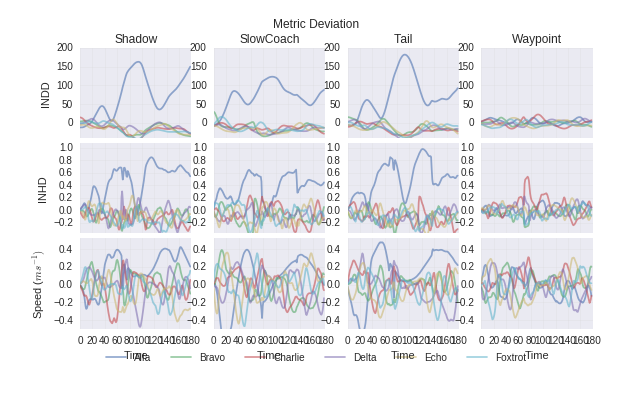

In [120]:
observer='Bravo'
run=0
data = trust_observations.xs(observer, level='observer').xs(run, level='run')
deviance = pd.concat([gf-gf.mean()for g,gf in data.groupby(level=['var','t'])])
fig = plot_behaviour_metric_graph(deviance, y_label_map={'Speed':'Speed ($ms^{-1})$'}, title="Metric Deviation", save_fig=True)

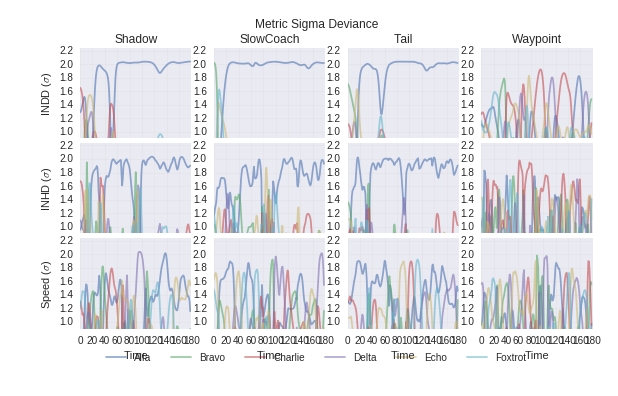

In [121]:
sigmas = pd.concat([(gf/(gf.std(axis=0))).abs() for g,gf in deviance.groupby(level=['var','t'])])
fig = plot_behaviour_metric_graph(
    sigmas,
    force_ymin=1.0,
    y_label_map={'INDD': 'INDD ($\sigma$)','INHD': 'INHD ($\sigma$)', 'Speed':'Speed ($\sigma$)'}, 
    title="Metric Sigma Deviance",
    save_fig=True
)

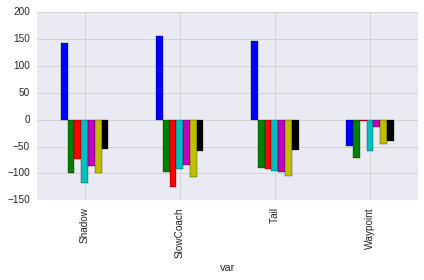

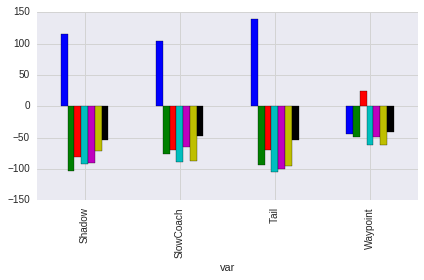

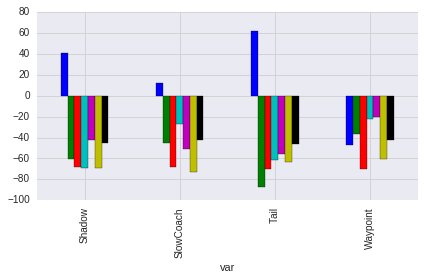

In [133]:
for metric in sigmas.columns:
    summed_sigmas=sigmas.unstack('target')[metric].groupby(level='var').sum()

    summed_sigmas['Mean']=summed_sigmas.mean(axis=1)
    summed_sigmas
    (summed_sigmas-180).plot(kind='bar', legend=False)
    #plt.title(metric)
    plt.grid(color='lightgray')
    plt.tight_layout()
    title = "summedsigmabar_{}".format(metric)
    plt.savefig(os.path.join(fig_path,title.replace(' ','_'))+'.png', transparent=True)


In [144]:
summed_sigmas=sigmas.unstack('target').groupby(level='var').sum()
summed_sigmas.stack('target').groupby(level='var').idxmax()

metric,INDD,INHD,Speed
var,,,
Shadow,"(Shadow, Alfa)","(Shadow, Alfa)","(Shadow, Alfa)"
SlowCoach,"(SlowCoach, Alfa)","(SlowCoach, Alfa)","(SlowCoach, Alfa)"
Tail,"(Tail, Alfa)","(Tail, Alfa)","(Tail, Alfa)"
Waypoint,"(Waypoint, Charlie)","(Waypoint, Charlie)","(Waypoint, Echo)"


In [218]:
for g,gf in summed_sigmas.stack('target').groupby(level='var'):
    maxes = gf.idxmax().apply(lambda t: t[1])
    #print g,maxes
    for k,v in gf.T.apply(dixon_test, axis=1).T.iteritems():
        print g,k,map(lambda l:l[-1], gf.loc[gf[k]==v].index.tolist())

Shadow INDD ['Alfa']
Shadow INHD ['Alfa']
Shadow Speed ['Alfa']
SlowCoach INDD ['Alfa']
SlowCoach INHD ['Alfa']
SlowCoach Speed []
Tail INDD ['Alfa']
Tail INHD ['Alfa']
Tail Speed ['Alfa']
Waypoint INDD []
Waypoint INHD ['Charlie']
Waypoint Speed []


In [217]:
q90 = [0.941, 0.765, 0.642, 0.56, 0.507, 0.468, 0.437, 
       0.412, 0.392, 0.376, 0.361, 0.349, 0.338, 0.329, 
       0.32, 0.313, 0.306, 0.3, 0.295, 0.29, 0.285, 0.281, 
       0.277, 0.273, 0.269, 0.266, 0.263, 0.26
      ]

q95 = [0.97, 0.829, 0.71, 0.625, 0.568, 0.526, 0.493, 0.466, 
       0.444, 0.426, 0.41, 0.396, 0.384, 0.374, 0.365, 0.356, 
       0.349, 0.342, 0.337, 0.331, 0.326, 0.321, 0.317, 0.312, 
       0.308, 0.305, 0.301, 0.29
      ]

q99 = [0.994, 0.926, 0.821, 0.74, 0.68, 0.634, 0.598, 0.568, 
       0.542, 0.522, 0.503, 0.488, 0.475, 0.463, 0.452, 0.442, 
       0.433, 0.425, 0.418, 0.411, 0.404, 0.399, 0.393, 0.388, 
       0.384, 0.38, 0.376, 0.372
       ]

Q90 = {n:q for n,q in zip(range(3,len(q90)+1), q90)}
Q95 = {n:q for n,q in zip(range(3,len(q95)+1), q95)}
Q99 = {n:q for n,q in zip(range(3,len(q99)+1), q99)}

def dixon_test(data, left=True, right=True, q_dict=Q95):
    """
    Keyword arguments:
        data = A ordered or unordered list of data points (int or float).
        left = Q-test of minimum value in the ordered list if True.
        right = Q-test of maximum value in the ordered list if True.
        q_dict = A dictionary of Q-values for a given confidence level,
            where the dict. keys are sample sizes N, and the associated values
            are the corresponding critical Q values. E.g.,
            {3: 0.97, 4: 0.829, 5: 0.71, 6: 0.625, ...}
            
    Returns a list of 2 values for the outliers, or None.
    E.g.,
       for [1,1,1] -> [None, None]
       for [5,1,1] -> [None, 5]
       for [5,1,5] -> [1, None]
       
    http://sebastianraschka.com/Articles/2014_dixon_test.html#building-dictionaries-for-q-value-look-up
    
    """
    assert(left or right), 'At least one of the variables, `left` or `right`, must be True.'
    assert(len(data) >= 3), 'At least 3 data points are required'
    assert(len(data) <= max(q_dict.keys())), 'Sample size too large'
    
    sdata = sorted(data)
    Q_mindiff, Q_maxdiff = (0,0), (0,0)
    
    if left:
        Q_min = (sdata[1] - sdata[0]) 
        try:
            Q_min /= (sdata[-1] - sdata[0])
        except ZeroDivisionError:
            pass
        Q_mindiff = (Q_min - q_dict[len(data)], sdata[0])
        
    if right:
        Q_max = abs((sdata[-2] - sdata[-1]))
        try:
            Q_max /= abs((sdata[0] - sdata[-1]))
        except ZeroDivisionError:
            pass
        Q_maxdiff = (Q_max - q_dict[len(data)], sdata[-1])

    if not Q_mindiff[0] > 0 and not Q_maxdiff[0] > 0:
        outliers = [None]
    
    elif Q_mindiff[0] == Q_maxdiff[0]:
        outliers = [Q_mindiff[1], Q_maxdiff[1]]
        
    elif Q_mindiff[0] > Q_maxdiff[0]:
        outliers = [Q_mindiff[1]]
    
    else:
        outliers = [Q_maxdiff[1]]
    
    return outliers

In [220]:
summed_sigmas

metric           INDD                                                  \
target           Alfa       Bravo     Charlie       Delta        Echo   
var                                                                     
Shadow     323.003861   79.986370  107.202271   62.076080   94.257987   
SlowCoach  334.819758   83.487390   54.470306   89.002178   94.920254   
Tail       325.549242   90.481784   88.007524   85.343505   81.968677   
Waypoint   130.301763  107.950612  178.233443  121.252396  166.429579   

metric                       INHD                                      \
target        Foxtrot        Alfa       Bravo     Charlie       Delta   
var                                                                     
Shadow      81.154381  294.407763   76.361021   98.626296   88.318089   
SlowCoach   74.155590  284.529077  103.731349  110.171443   91.336675   
Tail        74.290119  319.233937   86.241482  109.896094   75.765523   
Waypoint   134.154998  135.772469  131.562733  204.252885  117.440919   

metric                                  Speed                          \
target           Echo     Foxtrot        Alfa       Bravo     Charlie   
var                                                                     
Shadow      89.228494  108.682938  220.782828  119.876158  111.696403   
SlowCoach  114.826876   92.845564  191.933686  134.511951  111.880094   
Tail        80.118897   84.959442  242.422163   92.762922  110.353675   
Waypoint   130.568097  118.464506  132.504318  143.063382  110.395155   

metric                                         
target          Delta        Echo     Foxtrot  
var                                            
Shadow     110.617857  137.798933  111.000018  
SlowCoach  153.211456  128.909892  107.299464  
Tail       118.313961  124.255331  116.770735  
Waypoint   158.157117  159.532037  119.756016

In [241]:
intergfs=[]
for g,gf in summed_sigmas.stack('target').groupby(level='var'):
    maxes = gf.idxmax().apply(lambda t: t[1])
    _intergf=gf.unstack('target').stack('metric')
    intergfs.append(_intergf['Alfa'] / _intergf.drop('Alfa', axis=1).mean(axis=1))
print pd.concat(intergfs).unstack('metric').to_latex()

\begin{tabular}{lrrr}
\toprule
metric &      INDD &      INHD &     Speed \\
var       &           &           &           \\
\midrule
Shadow    &  3.802935 &  3.191642 &  1.867909 \\
SlowCoach &  4.227141 &  2.773664 &  1.509357 \\
Tail      &  3.874741 &  3.652717 &  2.155030 \\
Waypoint  &  0.920183 &  0.966642 &  0.958920 \\
\bottomrule
\end{tabular}



In [346]:
pd.concat([(gf/(gf.std(axis=0)/2)).abs() for g,gf in deviance.groupby(level=['var','t'])]).head()

metric                INDD      INHD     Speed
var    t target                               
Shadow 1 Alfa     0.531843  1.120639  1.987280
         Bravo    0.183859  0.501220  2.170988
         Charlie  0.699405  0.344851  0.616896
         Delta    0.622377  2.940391  2.549092
         Echo     3.198982  2.978228  1.413360

In [347]:
pd.concat([(gf/(gf.std(axis=0))).abs() for g,gf in deviance.groupby(level=['var','t'])]).head()

metric                INDD      INHD     Speed
var    t target                               
Shadow 1 Alfa     0.265922  0.560320  0.993640
         Bravo    0.091929  0.250610  1.085494
         Charlie  0.349702  0.172426  0.308448
         Delta    0.311189  1.470196  1.274546
         Echo     1.599491  1.489114  0.706680

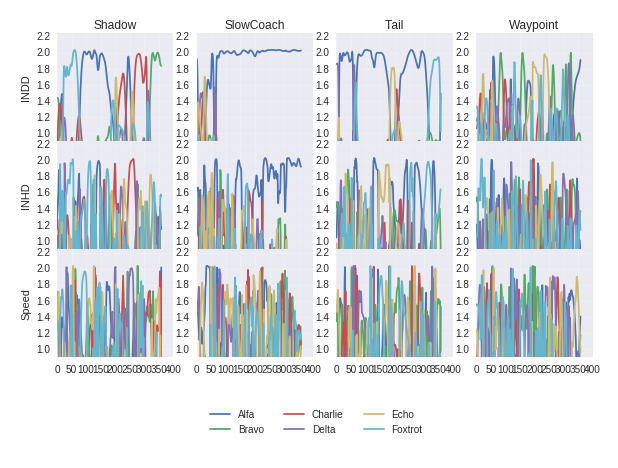

In [280]:
deviance = pd.concat([gf-gf.std(axis=1)for g,gf in data.groupby(level=['var','t'])])
#deviance.std(axis=1)
deviance.unstack('metric').stack('target').head()
fig = plot_behaviour_metric_graph(deviance.unstack('metric').stack('target'))

ValueError: cannot join with no level specified and no overlapping names

In [267]:
pd.concat([gf.std(axis=1) for g,gf in deviance.stack('metric').unstack('target').groupby(level=['var','t'])])

var       t    metric
Shadow    1    INDD       3.865078
               INHD       0.027497
               Speed      0.031088
          2    INDD       4.030194
               INHD       0.071647
               Speed      0.083160
          3    INDD       4.344301
               INHD       0.099999
               Speed      0.120612
          4    INDD       4.775231
               INHD       0.113893
               Speed      0.150675
          5    INDD       5.257735
               INHD       0.115398
               Speed      0.179217
          6    INDD       5.757386
               INHD       0.118566
               Speed      0.213212
          7    INDD       6.265011
               INHD       0.125318
               Speed      0.243495
          8    INDD       6.786922
               INHD       0.132483
               Speed      0.245725
          9    INDD       7.310967
               INHD       0.139897
               Speed      0.211502
          10   INDD       7.84753

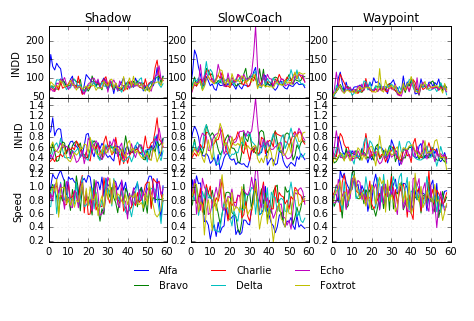

In [250]:
fig_600

Alfa
Bravo
Charlie
Delta
Echo
Foxtrot


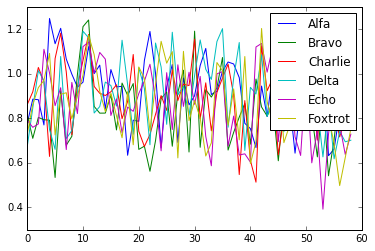

In [73]:
for target, target_df in metrics_df[metric].groupby(level='target'):
    print target
    plt.plot(target_df.values, label=target)
plt.legend()

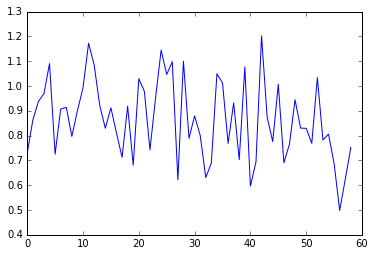

In [70]:
from matplotlib import pylab as plt
plt.plot(target_df.values)

In [94]:
metrics_df.unstack('target').stack().as_matrix()[0,:]
deviance = metrics_df-metrics_df.groupby(level=['var']).apply(np.mean, axis=0)
deviance.std(axis=1).head()


var       t  target 
Waypoint  1  Alfa       10.931509
             Bravo      12.341216
             Charlie    15.811806
             Delta      12.118861
             Echo       13.405424
dtype: float64

In [102]:
deviance.groupby(level='target').mean()

,INDD,INHD,Speed
target,,,
Alfa,5.228373,0.004306,0.043817
Bravo,-1.053045,-0.031529,-0.050369
Charlie,-1.352770,0.022393,0.011455
Delta,-0.501435,0.012146,0.025211
Echo,-1.294641,-0.016498,-0.017055
Foxtrot,-1.026482,0.009182,-0.013059


In [103]:
metrics_df

INDD      INHD     Speed
var      t  target                                 
Waypoint 1  Alfa      54.731743  0.325739  0.775881
            Bravo     52.342929  0.391801  0.815651
            Charlie   46.310339  0.303472  0.860593
            Delta     52.621357  0.322391  0.671606
            Echo      50.448837  0.314564  0.791046
            Foxtrot   50.492998  0.266297  0.727580
         2  Alfa      56.762001  0.402809  0.885302
            Bravo     59.731078  0.300238  0.709745
            Charlie   54.988406  0.475705  0.918082
            Delta     51.947023  0.417602  0.845850
            Echo      69.510130  0.612911  0.759155
            Foxtrot   59.478915  0.412247  0.862015
         3  Alfa      62.737380  0.424032  0.882851
            Bravo     63.767673  0.327990  0.803456
            Charlie   71.514178  0.421659  1.027422
            Delta     80.248158  0.582589  1.013364
            Echo     115.745870  0.914177  0.774228
            Foxtrot   63.316312  0.350543  0.937216
         4  Alfa      99.990415  0.800024  0.769718
            Bravo     70.428725  0.398036  0.793041
            Charlie   76.757211  0.652243  0.963110
            Delta     72.711807  0.588278  0.966070
            Echo      80.422655  0.671409  1.108684
            Foxtrot   73.565365  0.431984  0.969285
         5  Alfa     115.751474  0.698440  1.246719
            Bravo     82.890400  0.496991  0.791247
            Charlie  110.393537  0.863111  0.628708
            Delta     76.821243  0.403113  0.749148
            Echo      73.518234  0.406273  1.002880
            Foxtrot   80.083139  0.477449  1.090348
...                         ...       ...       ...
         55 Alfa      97.574387  0.360717  0.632065
            Bravo     73.198518  0.346860  0.542051
            Charlie   67.297541  0.407320  0.899858
            Delta     73.388964  0.396708  0.859098
            Echo      68.713339  0.435630  0.728865
            Foxtrot   75.398586  0.575681  0.806057
         56 Alfa      73.067402  0.325211  0.661643
            Bravo     87.068616  0.409670  0.703622
            Charlie   76.825071  0.438159  0.830421
            Delta     87.234260  0.615052  0.617950
            Echo      71.896904  0.478994  0.927326
            Foxtrot   72.797857  0.403123  0.687483
         57 Alfa      70.492597  0.378505  0.825380
            Bravo     66.613274  0.363235  0.931372
            Charlie   73.868503  0.396319  0.716194
            Delta     75.517278  0.476921  0.741178
            Echo      72.885721  0.430514  0.770911
            Foxtrot   59.766687  0.406855  0.498055
         58 Alfa      82.553627  0.497792  0.933029
            Bravo     80.715645  0.318071  0.768087
            Charlie   76.354461  0.453670  0.804371
            Delta     75.800917  0.398704  0.694369
            Echo      70.871885  0.464602  0.637662
            Foxtrot   85.684450  0.403607  0.623810
         59 Alfa      73.746942  0.368007  0.940411
            Bravo     75.240616  0.411951  0.845872
            Charlie   70.021631  0.389284  0.910078
            Delta     55.473107  0.292934  0.701358
            Echo      63.377700  0.316554  0.728375
            Foxtrot   68.091185  0.173878  0.752387

[354 rows x 3 columns]

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.011, -0.024, -0.026,
       -0.019, -0.003,  0.021,  0.053,  0.09 ,  0.134,  0.183,  0.237,
        0.296,  0.358,  0.424,  0.493,  0.565,  0.64 ])

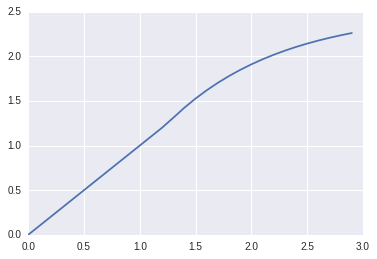

In [30]:
cruisev = 1.25
maxv=2.5

def f(x):
    if x > cruisev:
        return (cruisev + ((maxv-cruisev)*(1-np.exp(-(x-cruisev)))))
    else:
        return x
plt.plot(np.arange(0,3,0.1),map(f,np.arange(0,3,0.1)))
np.arange(0,3,0.1)-map(f,np.arange(0,3,0.1))

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.011, -0.024, -0.026,
       -0.019, -0.003,  0.021,  0.053,  0.09 ,  0.134,  0.183,  0.237,
        0.296,  0.358,  0.424,  0.493,  0.565,  0.64 ])

In [424]:
x=np.asarray([-0.436,-0.922,-0.857])

In [425]:
np.linalg.norm(x)

1.3321520183522599

In [428]:
f(x)

array([-4.431, -8.768, -8.059])